# Predicting Diabetes Hospital Readmission

### Table of Contents

1. [Introduction](#introduction)  
2. [Data Exploration & Initial Analysis](#data-exploration--initial-analysis)  
3. [Feature Engineering & Custom Transformers](#feature-engineering--custom-transformers)  
4. [Handling Class Imbalance](#handling-class-imbalance)  
5. [Building Modelling Pipelines](#building-modelling-pipelines)  
6. [Model Evaluation](#model-evaluation)  
7. [Interpretability](#interpretability)  
8. [Model Tuning & Optimisation](#model-tuning--optimisation)

## 1. Introduction

### Project Overview

In this project, I aim to predict **30-day hospital readmissions for diabetes patients** using the [UCI Diabetes 130-US Hospitals Dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008).

The dataset contains ten years of clinical data from over 130 U.S. hospitals and integrated delivery networks, and is openly licensed for public use.

### Why it matters

Hospital readmissions are a critical issue in healthcare due to:

- **Patient Risk:** Readmissions often reflect missed opportunities for preventative measures, increasing the likelihood of complications and worse long-term outcomes.
- **Financial Cost:** Unplanned readmissions increase healthcare costs.

Being able to **predict readmission risk** enables healthcare providers to proactively identify high-risk patients, prioritize follow-up care, and reduce avoidable costs.


### Imports

In [ ]:
# Standard library
import os
import sys
import random
from pathlib import Path

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.feature_selection import mutual_info_classif

# Imbalanced-learn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

# XGBoost
from xgboost import XGBClassifier

# Custom project modules (from src/)
from src.utils import view_categorical_variables, make_mi_scores, plot_performance, build_pipeline
from src.transformers import GlobalImputer, FeatureEngineer, DiagnosisCategoriser, CategorySetter, SMOTENCSampler, UnderSampler

## 2. Data Exploration & Initial Analysis

First, we fetch data using the ucimlrepo library and view the features.

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296) 
  
# data (as pandas dataframes) 
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features 
y_raw = diabetes_130_us_hospitals_for_years_1999_2008.data.targets
  
# metadata 
print(diabetes_130_us_hospitals_for_years_1999_2008.metadata) 
  
# variable information 
print(diabetes_130_us_hospitals_for_years_1999_2008.variables) 

{'uci_id': 296, 'name': 'Diabetes 130-US Hospitals for Years 1999-2008', 'repository_url': 'https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008', 'data_url': 'https://archive.ics.uci.edu/static/public/296/data.csv', 'abstract': 'The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The goal is to determine the early readmission of the patient within 30 days of discharge.\nThe problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide pro

c:\Users\frase\JupyterBasics\PredictingDiabetesReadmission\venv\Lib\site-packages\ucimlrepo\fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


The first thing to note is that there are two identification variables `encounter_ID` and `patient_nbr`, which should be discarded. Selecting the features attribute excludes them both. 

### 2.1 Missing Data

In [4]:
X.isna().sum()

race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide     

Three columns stand out as having lots of missing data: `weight`, `max_glu_serum` and `A1Cresult`. These have 96.9%, 94.7% and 83.3% missing values respectively.

Unfortunately, all three of these features are very medically relevant and are likely to be very informative in a patient's readmission risk. 

`A1Cresult` is a measure of blood sugar levels over recent months and is used to monitor and diagnose diabetes. It is likely to be highly predictive. There are still 16.7% of values and so given the importance of the feature, we will keep it. Missingness might even be meaningful (if missing means no test was administered, for example), so imputing with a new 'missing' category may be informative. 

`max_glu_serum` is a measure of blood sugar levels at the point of testing, also used to monitor and diagnose diabetes. We would also expect this to be highly predictive, maybe even more so than A1C testing because it may have stronger implications for the future since it is more 'up-to-date'. Again, we will keep this column, imputing with 'missingness' for the same reasons as above.

`weight`, as we see in the next section, is a categorical feature with fairly large buckets (25lbs). Without a height feature to compare to, it's difficult to use weight in a predictive sense, with no ability to calculate BMI which might give us a more accurate picture of its impact. Combined with the fact that it has the highest % of missing data, this leads us to drop the feature entirely. 


In [5]:
# Drop weight column
X = X.drop('weight', axis=1)

### 2.2 Categorical Variables

There is a high proportion of categorical data. Features like `age` are recorded categorically, in buckets (not numerically, as we might expect). These, and others like the medicine features, are all ordinal categorical features and should be encoded accordingly. 

`view_categorical_variables` allows us to see the unique values of each categorical variable: (full function in `transformers.py`)

In [6]:
view_categorical_variables(X)


race -> ['Caucasian' 'AfricanAmerican' nan 'Other' 'Asian' 'Hispanic']

gender -> ['Female' 'Male' 'Unknown/Invalid']

age -> ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']

payer_code -> [nan 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']

medical_specialty -> ['Pediatrics-Endocrinology' nan 'InternalMedicine'
 'Family/GeneralPractice' 'Cardiology' 'Surgery-General' 'Orthopedics'
 'Gastroenterology' 'Surgery-Cardiovascular/Thoracic' 'Nephrology'
 'Orthopedics-Reconstructive' 'Psychiatry' 'Emergency/Trauma'
 'Pulmonology' 'Surgery-Neuro' 'Obsterics&Gynecology-GynecologicOnco'
 'ObstetricsandGynecology' 'Pediatrics' 'Hematology/Oncology'
 'Otolaryngology' 'Surgery-Colon&Rectal' 'Pediatrics-CriticalCare'
 'Endocrinology' 'Urology' 'Psychiatry-Child/Adolescent'
 'Pediatrics-Pulmonology' 'Neurology' 'Anesthesiology-Pediatric'
 'Radiology' 'Pediatrics-Hematology-Oncology' 'Psychology' 'Podiatry'

Of great notice here are a few very high cardinality NOMINAL features: `diag_1/2/3`, `medical_specialty`, `payer_code`, `discharge_disposition_id`, `admission_source_id`. These cause massive feature explosion when using one-hot encoding. 

With tree-based models, we can use ordinal encodings instead to avoid this issue, because tree-based models won't inherently evaluate arithmetic differences between categories (they don't see them as continuous values). Even so, ordinal encoding a very high number of values makes it far more difficult to find effective splits, so performance might be negatively affected.

With linear models, using ordinal encodings is not an option since it will interpret the new numerical input linearly, which we don't want in a nominal category. 

Therefore, we should take steps to reduce the cardinalities of these features, and avoid feature explosion. This will be done in the custom transformers `DiagnosisCategoriser` and `CategorySetter`.

### 2.3 Data Imbalance

Another challenge here is the large class imbalance in the data, once reduced into binary classification. 

In [7]:
# convert target into a binary variable
y = (y_raw == '<30').astype(int)

neg_class_size = int((y == 0).sum().item())
pos_class_size = int((y == 1).sum().item())

print(f'Negative class proportion: {(100*(neg_class_size)/(pos_class_size+neg_class_size)):.2f}%')

Negative class proportion: 88.84%


To overcome this, I will test three different approaches and compare the results: undersampling, oversampling and no modification. I will go into more detail on the approaches and why they were chosen in [Handling Class Imbalance](#Handling-Class-Imbalance).

### 2.4 MI Scores

Finally, I will compute MI scores to get a quick insight into which features have strong statistical relationships with the target variable. I will use these scores to inform feature engineering. (Function is found in `functions.py`)

c:\Users\frase\JupyterBasics\PredictingDiabetesReadmission\venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Axes: >

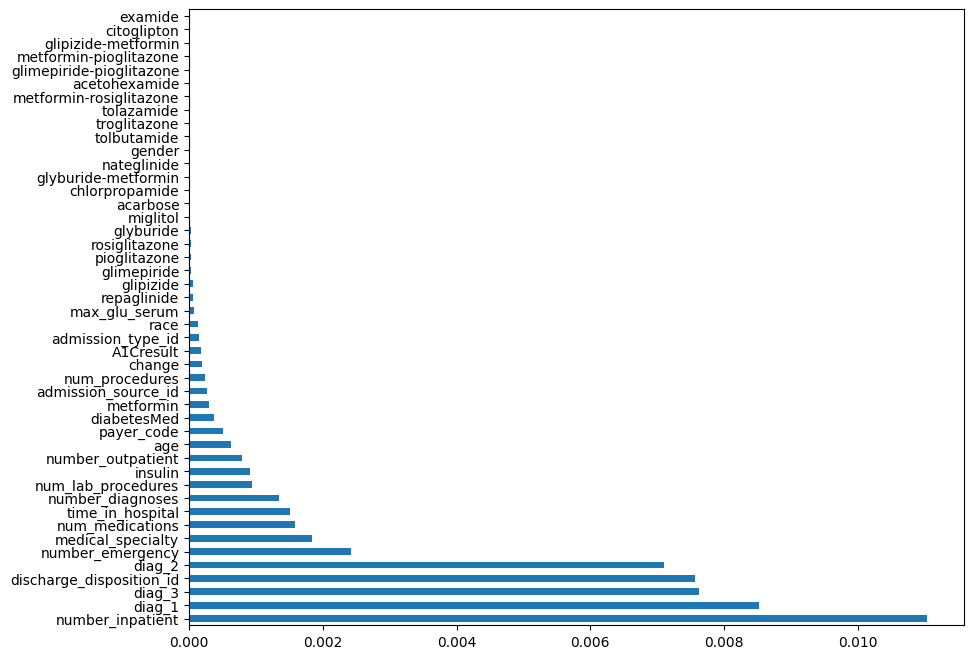

In [8]:
make_mi_scores(X, y).plot(kind='barh', figsize=(10, 8))

## 3. Feature Engineering & Custom Transformers

Firstly, I split features into categories, so that my custom transformers can be applied to the correct columns in my pipelines.

In [9]:
# nominal features
nom_cat_features = ['race', 'gender', 'payer_code','medical_specialty',
                'change', 'diabetesMed', 'admission_type_id','discharge_disposition_id',
                'admission_source_id']


medicine_features = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide',
                     'glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose',
                     'miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin',
                     'glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']

ord_cat_features = medicine_features + ['age', 'max_glu_serum', 'A1Cresult']

# numeric features of X, excluding irrelevant features encounter_id and patient_nbr
num_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

final_num_features = num_features + ['hosp_interaction', 'emergency_ratio', 'visit_intensity']

cat_features = nom_cat_features + ord_cat_features + ['diag_1', 'diag_2', 'diag_3']

cat_features_indices = [X.columns.get_loc(col) for col in cat_features]


### 3.1 Imputation

To deal with missing data, we define `GlobalImputer`, a custom transformer that imputes median value for numerical features and a new 'missing' value for categorical features (full code in `transformers.py`)

A new 'missing' value is preferred because for many features (like `diag_1`, or `A1Cresult` as discussed earlier), a missing value holds important information and should be treated accordingly. 

In [10]:
# instantiate the GlobalImputer class (used later in our pipeline)
imputer = GlobalImputer(num_features=num_features, cat_features=cat_features)

### 3.2 Feature Engineering

We choose to engineer only numerical features, due to the relatively higher MI scores (outside of the diagnoses features - for which we already have a derivative feature `number_diagnoses`) and also simplicity.

In the future, I would like to experiment more with categorical feature engineering - especially looking more closely at `diag_1/2/3`.

Engineered features: 
- `X['hosp_interaction'] = X['number_outpatient'] + X['number_emergency'] + X['number_inpatient']`

Total hospital interactions in the previous year. 

- `X['emergency_ratio'] = X['number_emergency'] / (X['hosp_interaction'] + 1)`

Ratio of emergency visits to total visits.

- `X['visit_intensity'] = (X['num_procedures'] + X['num_lab_procedures'] + X['num_medications']) / (X['time_in_hospital'])`

A measure of how many 'actions' were taken during the visit. (Denominator is always non-zero so division is safe.)

`FeatureEngineer` is found in `transformers.py`.

In [11]:
# instantiate the FeatureEngineer class (used later in our pipeline)
featureEngineer = FeatureEngineer()

### 3.3 Grouping Diagnoses Values To Reduce Cardinality

`DiagnosisCategoriser` is a custom transformer class which buckets diagnoses codes according to the type of diagnosis (found in `transformers.py`).

The features `diag_1`, `diag_2` and `diag_3` all contain ICD-9 codes, which can be conveniently grouped according to their first digit. This reduces the number of unique values from 716 to 20, but preserves diagnostic information because the groupings are meaningful. 

In [12]:
# instantiate the DiagnosisCategoriser class (used later in our pipeline)
DiagCategoriser = DiagnosisCategoriser()

### 3.4 Encoding

`CategorySetter` is a custom transformer class that prepares categorical features for encoding (found in `transformers.py`).

For high cardinality features, we include the top 10 most common values and bucket the rest into a new value `other`. 
We give all nominal features the category data type (some were integer initially) and add a category for the new imputed 'missing' values.

For ordinal categorical features, we use define orderings and apply them using `.astype(CategoricalDtype(categories=levels, ordered=True))`, so they can be later interpreted by `OrdinalEncoder`.

We will apply CategorySetter twice (once to nominal feature columns and once to ordinal feature columns), so it takes the targeted feature names as an argument.

In [13]:
# instantiate the CategorySetter to be applied to nominal features
NominalCategorySetter = CategorySetter([feature for feature in nom_cat_features])

# instantiate the CategorySetter to be applied to ordinal features (except diag_1, diag_2, diag_3)
OrdinalCategorySetter = CategorySetter([feature for feature in ord_cat_features if feature not in ['diag_1', 'diag_2', 'diag_3']])

## 4. Handling Class Imbalance

As seen earlier, the negative class dominates the sample with a majority of ~89%. 
Class imbalance is of particular concern in this problem.

False negatives (when the model predicts no readmission but the patient is readmitted) are to be minimised. Such a scenario indicates that an at-risk patient has been missed, and the opportunity for preventative action not taken. They are less desirable than false positives, which although implying extra costs in time or treatment, is less costly than later readmission.

With such a severe imbalance in its favour, we expect the model to perform far better on the negative class. It's likely that the model doesn't predict many positives at all, which would leave us with lots of false negatives. 

These considerations make it all the more important to take steps that can minimise the impact of this imbalance.
Here, three different approaches (oversampling, undersampling, no action) are taken and the results compared.

### 4.1 No Sampling

The first approach is not to apply any sampling techniques at all. We might hope that the trends in the positive class are so clear that models are still able to identify them, despite the low quantity of data. There is also the opportunity to instead change the treshold of predictions to a much lower value, thus making the model more likely to predict positives and reduce the number of false negatives. 

### 4.2 Oversampling

To oversample, we take the approach of creating synthetic data by employing SMOTE (Synthetic Minority Over-sampling Technique), instead of duplicating the few positive examples. This is done to avoid overfitting based on a very small number of positive instances. 

Here, we use `SMOTENC`, a function which accepts categorical data to create `SMOTENCSampler` (found in `transformers.py`).

In [14]:
# instantiate the SMOTENCSampler class used in pipelines
smotenc = SMOTENCSampler(cat_features_indices=cat_features_indices, random_state=0)

### 4.3 Undersampling

To undersample, we use `RandomUnderSampler` to create transformer `UnderSampler` (found in `transformers.py`).

In [15]:
# instantiate the UnderSampler class used in pipelines
undersample = UnderSampler(random_state=0)

### 4.4 Implementation

These transformers use `fit_resample` methods, which can be applied in `imblearn` pipelines but not `sklearn`. 
They will be applied always as the first step in the pipeline. We do not want to generate synthetic data based on engineered features, or rescaled/encoded data. Any preprocessing will be done after the sampling has taken place, to preserve data integrity. 

## 5. Building Modelling Pipelines

### 5.1 The `build_pipeline` Function

The function `build_pipeline` (found in `functions.py`) will build the pipelines, taking four main arguments. 
1. `model` - the classifier used. Here we will compare three: Logistic Regression, Random Forest and xgboost.
2. `model_type` - whether the classifier is linear or tree-based, which will affect encoding decisions. 
3. `include_feat_eng` - whether to include engineered features.
4. `sampling` - the sampling method to use.

It also takes as arguments the `nom_cat_features`, `ord_cat_features`, `final_num_features` and `cat_features_indices`. 
This is to preserve modularity, though they will not be varied here. 

This modular approach allows much easier testing, to measure the impact of different steps and approaches. 

`model_type` is important because, as was discussed in [Data Exploration and Analyses](#Data-Exploration-and-Analyses), tree-based models can make use of ordinal encodings on nominal features. In a logistic regression pipeline, we will use one-hot encoding on ONLY ordinal features, but for tree-based models we will use ordinal encoding for both, in order to reduce feature explosion. 

### 5.2 Structure of Pipelines

The modelling pipelines are built in a modular and logical sequence to ensure data integrity, and effective preprocessing:

1. **Sampling (Optional)**  
   Sampling (e.g. SMOTENC, undersampling) is applied **before** any transformations to avoid:
   - Generating synthetic samples from engineered features  
   - Sampling after scaling/encoding which would be more computationally expensive 
   

2. **Imputation**  
   Missing values are imputed early so that:
   - Feature engineering can use complete data  
   - Encoders handle missing values properly in categorical features (as a separate category)

3. **Feature Engineering**  
   New features are created **before** preprocessing (e.g. scaling or encoding) so that they're included in the scaling

4. **Preprocessing (ColumnTransformer)**  
   The `ColumnTransformer` handles multiple preprocessing paths based on feature type:

   - **Diagnosis Codes (`diag_1`, `diag_2`, `diag_3`)**:  
     - Passed through `DiagnosisCategoriser`  
     - Encoded (One-hot for linear, Ordinal for tree-based)

   - **Numerical Features**:  
     - Scaled using `StandardScaler`

   - **Nominal Categorical Features** (excluding diagnosis):  
     - Passed through `CategorySetter`  
     - Encoded (One-hot for linear, Ordinal for tree-based)

   - **Ordinal Categorical Features**:  
     - Always encoded with `OrdinalEncoder`  


5. **Classifier**  
   Finally, the preprocessed data is passed to the model (LogisticRegression, RandomForest, XGBoost).

---

### 🔄 Encoding Strategy Summary

| Feature Type             | Linear Models      | Tree-Based Models     |
|--------------------------|--------------------|------------------------|
| `diag_1`, `diag_2`, `diag_3` | OneHotEncoder      | OrdinalEncoder         |
| Nominal Categorical      | OneHotEncoder      | OrdinalEncoder         |
| Ordinal Categorical      | OrdinalEncoder     | OrdinalEncoder         |
| Numerical                | StandardScaler     | (Often left raw)       |

![Pipeline Diagram](images/pipeline_diagram.png)

### 5.3 Building Pipelines

Now we build pipelines: three variants for three different models: Logistic Regression, Random Forest and XGBoost. 

In [16]:
lr_models = {'standard_LR' : build_pipeline(model_type='linear', include_feat_eng=True, model=LogisticRegression(max_iter=500, random_state=0), nom_cat_features=nom_cat_features, ord_cat_features=ord_cat_features, final_num_features=final_num_features, cat_features_indices=cat_features_indices),
               'over_LR':  build_pipeline(model_type='linear', include_feat_eng=True, sampling='oversample', model=LogisticRegression(max_iter=500, random_state=0), nom_cat_features=nom_cat_features, ord_cat_features=ord_cat_features, final_num_features=final_num_features, cat_features_indices=cat_features_indices),
                'under_LR':  build_pipeline(model_type='linear', include_feat_eng=True, sampling='undersample', model=LogisticRegression(max_iter=500, random_state=0), nom_cat_features=nom_cat_features, ord_cat_features=ord_cat_features, final_num_features=final_num_features, cat_features_indices=cat_features_indices)
}

rf_models =  {'standard_RF' : build_pipeline(model_type='tree', include_feat_eng=True, model=RandomForestClassifier(n_estimators=100, random_state=0), nom_cat_features=nom_cat_features, ord_cat_features=ord_cat_features, final_num_features=final_num_features, cat_features_indices=cat_features_indices),
               'over_RF':  build_pipeline(model_type='tree', include_feat_eng=True, sampling='oversample', model=RandomForestClassifier(n_estimators=100, random_state=0), nom_cat_features=nom_cat_features, ord_cat_features=ord_cat_features, final_num_features=final_num_features, cat_features_indices=cat_features_indices),
                'under_RF':  build_pipeline(model_type='tree', include_feat_eng=True, sampling='undersample', model=RandomForestClassifier(n_estimators=100, random_state=0), nom_cat_features=nom_cat_features, ord_cat_features=ord_cat_features, final_num_features=final_num_features, cat_features_indices=cat_features_indices)
}

xgb_models =  {'standard_XGB' : build_pipeline(model_type='tree', include_feat_eng=True, model=XGBClassifier(eval_metric='auc', random_state=0), nom_cat_features=nom_cat_features, ord_cat_features=ord_cat_features, final_num_features=final_num_features, cat_features_indices=cat_features_indices),
               'over_XGB':  build_pipeline(model_type='tree', include_feat_eng=True, sampling='oversample', model=XGBClassifier(eval_metric='auc', random_state=0), nom_cat_features=nom_cat_features, ord_cat_features=ord_cat_features, final_num_features=final_num_features, cat_features_indices=cat_features_indices),
                'under_XGB':  build_pipeline(model_type='tree', include_feat_eng=True, sampling='undersample', model=XGBClassifier(eval_metric='auc', random_state=0), nom_cat_features=nom_cat_features, ord_cat_features=ord_cat_features, final_num_features=final_num_features, cat_features_indices=cat_features_indices)
}

## 6. Model Evaluation

### 6.1 Split Data

We split data into train, validation and test data, using `stratify` to preserve imbalance. Validation data will be used to tune hyperparameters and thresholds. The pipelines were built to ensure no data leakage. 

In [18]:
# split train and test data, using stratify to preserve class balance (or imbalanace in this case)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=0)

### 6.2 Evaluation Method

The function `evaluate_models` will evaluate model performance on the training data in cross-validation. The chosen metrics are average precision, precision, recall and F1. 

**Precision**: how many of the predicted readmissions are correct. In the present context, high precision means few **false alarms** - which might represent less resources wasted on preventative steps. 

**Recall**: how many of the actual readmissions are identified. In the present context, high recall means few **missed readmission risks** - which is of particular concern to us, for reasons discussed in the introduction.

**Average Precision**: a threshold-independent measure of precision and recall. 

**F1**: harmonic mean of precision and recall. This will be our **most important metric**. Always predicting positive guarantees high recall, always predicting negative guarantees high precision - neither of which is desirable, and a balance is critical. 

We also store model performance information in a dictionary `model_scores`, which we will plot afterwards. 

In [17]:
model_scores = {}

def evaluate_models(models):

    scoring = {
    'average_precision': 'average_precision',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
    }

    for model_name, model in models.items():
        cv_results = cross_validate(model, X_train, y_train, cv=3, scoring=scoring, n_jobs=-1)

        print(f'Model: {model_name}')
        for metric_name, metric_values in cv_results.items():
            print(f'  {metric_name}: {metric_values.mean():.4f}')
            model_scores[model_name] = {
                'f1': cv_results['test_f1'].mean(),
                'average_precision': cv_results['test_average_precision'].mean()
            }
        print("-" * 30) 
    pass


### 6.3 Evaluate and Visualise Performance

In [19]:
evaluate_models(lr_models)
evaluate_models(rf_models)
evaluate_models(xgb_models)

Model: standard_LR
  fit_time: 3.2728
  score_time: 1.6242
  test_average_precision: 0.2082
  test_precision: 0.4447
  test_recall: 0.0140
  test_f1: 0.0272
------------------------------
Model: over_LR
  fit_time: 87.7982
  score_time: 1.6805
  test_average_precision: 0.1416
  test_precision: 0.1457
  test_recall: 0.3156
  test_f1: 0.1994
------------------------------
Model: under_LR
  fit_time: 1.2868
  score_time: 1.5282
  test_average_precision: 0.2048
  test_precision: 0.1710
  test_recall: 0.5613
  test_f1: 0.2621
------------------------------
Model: standard_RF
  fit_time: 14.0889
  score_time: 2.8981
  test_average_precision: 0.1864
  test_precision: 0.4571
  test_recall: 0.0070
  test_f1: 0.0138
------------------------------
Model: over_RF
  fit_time: 87.9168
  score_time: 3.0312
  test_average_precision: 0.1410
  test_precision: 0.1604
  test_recall: 0.1262
  test_f1: 0.1412
------------------------------
Model: under_RF
  fit_time: 3.4361
  score_time: 2.5587
  test_avera

With `plot_performance` (found in `src/functions.py`), we can take the dictionary, convert it into a dataframe and visualise each model's performance. 

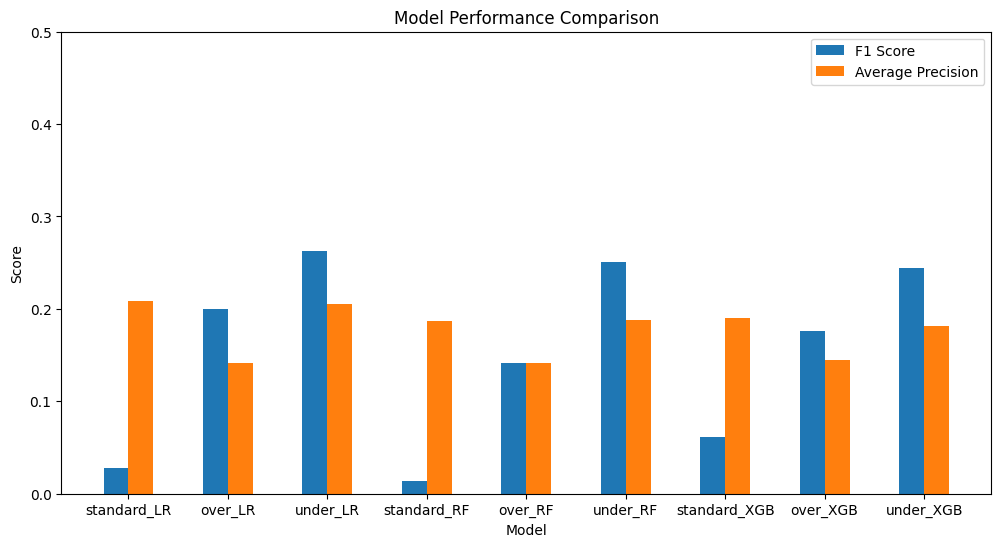

In [20]:
plot_performance(model_scores)

Observations on sampling:

1. Random undersampling performs significantly better than both SMOTENC and no sampling, across all models. Some precision is sacrificed, but the gain in recall is enormous, bringing up the f1 score. Given our focus on reducing false negatives, random undersampling seems to be the way to go. 

2. SMOTENC performs fairly poorly on this dataset, reducing average precision by up to 33% for linear regression compared to no sampling. There are lots of categorical features, some of which still have relatively high cardinalities (up to 20) which might make synthetic sampling more difficult. We can tell by the very long fit time that it is an expensive and complex process - one which may not be resulting in reliable, realistic data. In future, I would like to try oversampling to a smaller degree; increasing majority size to 30% for example, instead of the default 50%, might yield better results. 

3. No sampling, as expected, has extremely low recall. It struggles to identify negative cases, and apparently predicts positive nearly always. 

Observations on model performance:

1. It is important to note, first of all, that performance is not exceptionally good across all models. F1 scores are all well below 0.3, signifying relatively poor predictive performance when we consider both the positive and negative classes. 

2. Logistic Regression, combined with undersampling, actually performs the best in F1 and average precision. This might be due to less overfitting. It may be that the data is fairly low-signal, given its lack of information on lifestyle, genetic information, health indicators. Or high-noise, given the sheer number of features. The more complex tree-based models are more prone to overfitting. 

3. Despite scoring lower than Logistic Regression, XGBoost's performance may well be improved by parameter tuning which might reduce overfitting, and making use of the native `scale_pos_weight` parameter to deal with class imbalance. In a later section, I will maximise predictive performance by doing this with an XGBoost model. 

## 7. Logistic Regression and Interpretability

While model performance metrics like F1 score and average precision are important, they are not the only factors to consider in healthcare applications. In high-stakes contexts like the current one, **interpretability** is critical for enabling transparency and trust.

Although an optimised XGBoost may perform better, it is inherently complex and difficult to interpret. Its predictions are derived from an thousands of decision tree splits in the data, making it challenging to trace how individual input features contribute to a specific prediction. Practitioners will be understandably wary of utilising something so undescriptive. 

In contrast, Logistic Regression offers a high degree of interpretability. Model coefficients are easily accessible, which represent the impact of each feature on the outcome. This transparency allows practioners to understand where predictions are coming from, which is extremely important in a highly regulated and sensitive hospital environment. 

In our experiments, Logistic Regression combined with random undersampling not only delivered strong predictive performance (high F1 and average precision scores), but also maintained full interpretability. This balance between accuracy and transparency makes it the most suitable model for this context. 

## 8. Model Tuning & Optimisation

Despite the fact that Logistic Regression should be preferred due to its high interpretability over XGBoost, here I will optimise an 
XGBoost model to attain the highest F1 score possible, as an exercise and demonstration of performance enhancing techniques.

### 8.1 Native Imbalance Method

XGBoost actually has a native technique for dealing with class imbalance `scale_pos_weight`, which I will make use of here because it actually improves performance more than either `SMOTENC` or `RandomUnderSampler`.

In [27]:
class_imbalance = (y_train['readmitted'] == 0).sum()/(y_train['readmitted'] == 1).sum()



improved_model_pipeline = build_pipeline(model_type='linear',
                                        include_feat_eng=True, 
                                        model=XGBClassifier(eval_metric='logloss', random_state=0, scale_pos_weight=class_imbalance),
                                        nom_cat_features=nom_cat_features, ord_cat_features=ord_cat_features, final_num_features=final_num_features, cat_features_indices=cat_features_indices)

### 8.2 RandomizedSearch

Next we perform a randomized search to tune model parameters. 

In [28]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__min_child_weight': [1, 5, 10],
    'classifier__gamma': [0, 1, 5]
}

random_search = RandomizedSearchCV(
        estimator=improved_model_pipeline,
        param_distributions=param_grid,
        cv=5, 
        scoring='f1', 
        n_jobs=-1
    )
random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)
print("Validation Set Score:", random_search.score(X_valid, y_valid))

Best parameters found:  {'classifier__subsample': 0.6, 'classifier__n_estimators': 300, 'classifier__min_child_weight': 10, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.01, 'classifier__gamma': 1, 'classifier__colsample_bytree': 0.6}
Best cross-validation score:  0.2719444161755592
Validation Set Score: 0.2806174089068826


### 8.3 Thresholding

Finally, we'll optimise the threshold for positive prediction.

In [29]:
# change threshold
best_pipeline = random_search.best_estimator_
y_pred_proba = best_pipeline.predict_proba(X_valid)[:, 1]


thresholds = [0.4,0.45,0.5,0.55,0.6]

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    print(f'F1 score for threshold {threshold}: {f1_score(y_valid, y_pred):.4f}')

F1 score for threshold 0.4: 0.2379
F1 score for threshold 0.45: 0.2595
F1 score for threshold 0.5: 0.2806
F1 score for threshold 0.55: 0.2923
F1 score for threshold 0.6: 0.2823


We limit the testing values (between 0.4-0.6) to avoid overfitting to validation data. It appears a moderate increase to 0.55 may yield slight gains in performance. 

### 8.4 Final Testing

Now we'll made predictions on the test data and analyse performance. 

In [30]:
test_y_pred_proba = best_pipeline.predict_proba(X_test)[:,1]

opt_threshold = 0.55

test_y_pred = (test_y_pred_proba >= opt_threshold).astype(int)

test_f1 = f1_score(y_test, test_y_pred)
test_precision = precision_score(y_test, test_y_pred, )
test_recall = recall_score(y_test, test_y_pred, )

print(f'Final Test F1 Score: {test_f1:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')

Final Test F1 Score: 0.2791
Precision: 0.2098
Recall: 0.4170


While logistic regression demonstrated strong performance and high interpretability — making it a suitable choice in clinical settings — here we have used an XGBoost model in order to maximise predictive performance. After hyperparameter tuning and threshold optimization using validation data, the final XGBoost model achieved an F1 score of 0.2791 on the held-out test set, with a precision of 0.2098 and recall of 0.4170. These results display a modest but meaningful ability to identify patients at risk of 30-day readmission, with a solid recall rate of 40%. Given the priority of false negatives in this context, the trade-off with precision is acceptable. This highlights the performance gains achievable through boosting methods and hyperparameter tuning, even with a noisy and imbalanced dataset. 